In [1]:
import os
import pandas as pd
import numpy as np
import phate
import scprep
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import seaborn as sns
from PIL import Image
import palantir
from collections import Counter
from matplotlib.patches import Patch
import logging
import warnings
from tqdm import tqdm

In [3]:
'Load data'
ad = sc.read_h5ad('/home/qukun/ccp1997/GBM_10X/ng_revised/public_data/GBmap/GBmap_tumor_cell_pseudotime.h5ad')
ad

AnnData object with n_obs × n_vars = 45414 × 21384
    obs: 'author', 'donor_id', 'assay', 'tumor_subtype', 'tumor_subtype_MES_score', 'tumor_subtype_AC_score', 'tumor_subtype_OPC_score', 'tumor_subtype_NPC_score', 'annotation'
    obsm: 'X_umap'

In [4]:
'Set colors'
clust_colors = {'TAM1':'#17728C','TAM2':'#C1EDF6','TAM3':'#C5E5BD','TAM4':'#89CFC5','TAM5':'#AA5FAC','Monocytes':'#748EBF','DC cells':'#00C8FB',\
                'Oligodendrocyte':'#AE958C',\
                'B cells':'#ECD157', 'Plasma cells':'#DABB57',\
                'Treg cells':'#fc912a','T-IFI6':'#FF6666',\
                'Cytotoxic CD8T':'#FD9DC6','Exhausted CD8T':'#EEDCE4',\
                'CD4T':'#FFB3A1','T-HSPA1A':'#FFD9CE',\
                'NK cells':'#FF3D73',\
                'MES1':'#4169E1','MES2':'#D7008C','AC-like':'#FED100','OPC-like':'#00A555','NPC-like':'#16CB55',\
                'neurons':'#4C8266',\
                'Pericyte':'#C83726','VSMCs':'#922226','Endo':'#F51F1A'}

In [5]:
'Remove Neftel et al. dataset'
ad = ad[~ad.obs['donor_id'].isin(['MGH105','MGH115','MGH124','MGH143'])]
ad

View of AnnData object with n_obs × n_vars = 39615 × 21384
    obs: 'author', 'donor_id', 'assay', 'tumor_subtype', 'tumor_subtype_MES_score', 'tumor_subtype_AC_score', 'tumor_subtype_OPC_score', 'tumor_subtype_NPC_score', 'annotation'
    obsm: 'X_umap'

# Quality Control

In [ ]:
raw_adata = ad.raw.to_adata()
raw_adata.var['mt'] = raw_adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(raw_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [7]:
'Remove potential doublets'
adata = ad[raw_adata.obs[raw_adata.obs['n_genes_by_counts'] <= 4000].index]
adata

View of AnnData object with n_obs × n_vars = 32937 × 21384
    obs: 'author', 'donor_id', 'assay', 'tumor_subtype', 'tumor_subtype_MES_score', 'tumor_subtype_AC_score', 'tumor_subtype_OPC_score', 'tumor_subtype_NPC_score', 'annotation'
    obsm: 'X_umap'

# Select 1500 HVGs

In [ ]:
adata.obs['batch'] = adata.obs['author'].astype(str) + "_" + adata.obs['donor_id'].astype(str) + "_" + adata.obs['assay'].astype(str)
hvg_list = []
hvg_counter = Counter()
for sample in adata.obs['batch'].unique():
    sample_adata = adata[adata.obs['batch'] == sample]
    sc.pp.highly_variable_genes(sample_adata, n_top_genes=1500)
    hvg_genes = sample_adata.var[sample_adata.var['highly_variable']].index.tolist()
    cell_count = sample_adata.shape[0]
    for gene in hvg_genes:
        hvg_counter[gene] += 1

In [9]:
top_hvgs = [gene for gene, freq in hvg_counter.most_common(1500)]
len(top_hvgs)

1500

In [10]:
hvg_counter[top_hvgs[1499]]

4

In [11]:
adata.var['highly_variable'] = adata.var_names.isin(top_hvgs)

# Harmony Integrate

In [12]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True)
sc.external.pp.harmony_integrate(adata, 'batch')

2024-09-12 14:56:32,506 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-09-12 14:56:52,404 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-09-12 14:56:53,088 - harmonypy - INFO - Iteration 1 of 10
2024-09-12 14:57:11,805 - harmonypy - INFO - Iteration 2 of 10
2024-09-12 14:57:30,663 - harmonypy - INFO - Iteration 3 of 10
2024-09-12 14:57:48,523 - harmonypy - INFO - Iteration 4 of 10
2024-09-12 14:58:12,834 - harmonypy - INFO - Iteration 5 of 10
2024-09-12 14:58:39,143 - harmonypy - INFO - Iteration 6 of 10
2024-09-12 14:58:50,780 - harmonypy - INFO - Converged after 6 iterations


In [13]:
adata.obsm['X_pca_harmony'].shape

(32937, 50)

/home/qukun/zfh/miniconda3/envs/spare/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/qukun/zfh/miniconda3/envs/spare/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/qukun/zfh/miniconda3/envs/spare/lib/python3.8/site-packages/

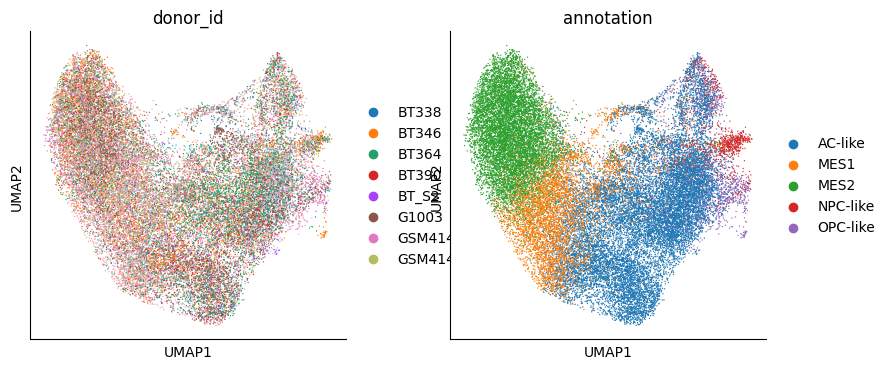

In [14]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['donor_id', 'annotation'])

# Calculate PHATE

In [15]:
EBT_counts = pd.DataFrame(adata.obsm['X_pca_harmony'], index=adata.obs.index)
phate_operator = phate.PHATE(n_jobs=-2)
Y_phate = phate_operator.fit_transform(EBT_counts)
df_phate = pd.DataFrame(Y_phate, index=adata.obs.index, columns=['Dim1', 'Dim2'])

Calculating PHATE...
  Running PHATE on 32937 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 92.41 seconds.
    Calculating affinities...
    Calculated affinities in 4.49 seconds.
  Calculated graph and diffusion operator in 97.32 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 7.98 seconds.
    Calculating KMeans...
    Calculated KMeans in 18.47 seconds.
  Calculated landmark operator in 29.32 seconds.
  Calculating optimal t...
    Automatically selected t = 25
  Calculated optimal t in 5.77 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 3.40 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 9.04 seconds.
Calculated PHATE in 144.93 seconds.


# Register Neftel et al. dataset

In [16]:
ad = sc.read_h5ad('/home/qukun/ccp1997/GBM_10X/ng_revised/public_data/GBmap/GBmap_tumor_cell_pseudotime.h5ad')
ad

AnnData object with n_obs × n_vars = 45414 × 21384
    obs: 'author', 'donor_id', 'assay', 'tumor_subtype', 'tumor_subtype_MES_score', 'tumor_subtype_AC_score', 'tumor_subtype_OPC_score', 'tumor_subtype_NPC_score', 'annotation'
    obsm: 'X_umap'

In [17]:
ad.obs['batch'] = ad.obs['author'].astype(str) + "_" + ad.obs['donor_id'].astype(str) + "_" + ad.obs['assay'].astype(str)
ad.var['highly_variable'] = ad.var_names.isin(top_hvgs)
sc.pp.pca(ad, n_comps=50, use_highly_variable=True)
sc.external.pp.harmony_integrate(ad, 'batch')
ad.obsm['X_pca_harmony'].shape

2024-09-12 15:04:03,074 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-09-12 15:04:28,481 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-09-12 15:04:29,254 - harmonypy - INFO - Iteration 1 of 10
2024-09-12 15:05:05,402 - harmonypy - INFO - Iteration 2 of 10
2024-09-12 15:05:33,625 - harmonypy - INFO - Iteration 3 of 10
2024-09-12 15:06:02,624 - harmonypy - INFO - Iteration 4 of 10
2024-09-12 15:06:31,046 - harmonypy - INFO - Iteration 5 of 10
2024-09-12 15:06:57,405 - harmonypy - INFO - Iteration 6 of 10
2024-09-12 15:07:17,021 - harmonypy - INFO - Iteration 7 of 10
2024-09-12 15:07:35,928 - harmonypy - INFO - Converged after 7 iterations


(45414, 50)

# KNN

In [18]:
group_A = ad.obsm['X_pca_harmony'][ad.obs.index.isin(df_phate.index)]
group_B = ad.obsm['X_pca_harmony'][ad.obs['donor_id'].isin(['MGH105','MGH115','MGH124','MGH143'])]
indices_A = ad.obs.index[ad.obs.index.isin(df_phate.index)].to_numpy()
indices_B = ad.obs.index[ad.obs['donor_id'].isin(['MGH105','MGH115','MGH124','MGH143'])].to_numpy()
distances = cdist(group_B, group_A, metric='euclidean')
print(f"Distances shape: {distances.shape}")
print(f"indices_A length: {len(indices_A)}")
print(f"indices_B length: {len(indices_B)}")
nearest_indices = np.argsort(distances, axis=1)[:, :5]
print(f"nearest_indices shape: {nearest_indices.shape}")
indices_A_array = np.array(indices_A)
assert nearest_indices.max() < len(indices_A_array), "Index out of bounds in nearest_indices."
nearest_neighbors = indices_A_array[nearest_indices]
nearest_neighbors_df = pd.DataFrame(
    nearest_neighbors,
    index=indices_B,
    columns=[f'Neighbor_{i+1}' for i in range(5)]
)
nearest_neighbors_df

Distances shape: (5799, 32937)
indices_A length: 32937
indices_B length: 5799
nearest_indices shape: (5799, 5)


,Neighbor_1,Neighbor_2,Neighbor_3,Neighbor_4,Neighbor_5
105_C1_12,SM017_ATTCATCAGGCAGTCA-1,SM017_TGATTCTTCGCTCCTA-1,BT364-AGATTGCCAGGCGATA,SM017_CCACGAGCAGATTTCG-1,GSM4141790_X1.662881e+14.5
105_C1_25,G1003.D_T_CAAGTTGGTATGCTTG,GSM4141790_X1.299784e+14.4,SF11209_TTATGCTCACTCGACG-1,G1003.A_T_GCACATAGTCACAAGG,G1003.A_T_ACGGCCATCCTCTAGC
105_C1_30,SF11247_CAGTCCTTCCTTGACC-1,SF11209_CCACGGACATCGTCGG-1,SF11247_CAACCAAGTGCACCAC-1,SF11209_CAGAGAGAGTACGCCC-1,G1003.D_T_GATTCAGCATTCTCAT
105_C1_31,GSM4141789_X1.917604e+14.1,GSM4141789_X1.614626e+14,SF11232_TTGCCGTGTCAGTGGA-1,SF11232_AAAGCAAAGCCATCGC-1,GSM4141789_X2.355593e+14.4
105_C1_38,SM017_TGTCCACGTTGTGCAT-1,GSM4141790_X2.009741e+14.3,SM017_AAGCGTTGTGCAAGAC-1,SM017_GACTCAAGTATGGTAA-1,SM017_TTCTAGTTCGGACTGC-1
...,...,...,...,...,...
143_7d_990,G1003.B_T_CATCCACGTGAGTATA,GSM4141789_X1.614627e+14.7,GSM4141790_X1.301942e+14,GSM4141789_X2.319171e+14.4,GSM4141790_X1.313096e+14.1
143_7d_994,GSM4141790_X1.927189e+14.4,G1003.A_T_CTCCTAGTCGGAAACG,G1003.A_T_AACTTTCCAGTACACT,SF11209_TGCGGGTGTAGGCATG-1,GSM4141790_X1.267078e+14.1
143_7d_996,GSM4141789_X1.225147e+14,SF11247_ATTGGACAGCGTTGCC-1,SF11247_TCTTTCCAGATCCTGT-1,G1003.C_T_ACTTTCAAGTGCAAGC,GSM4141790_X1.917089e+14.4
143_7d_997,G1003.C_T_GTGCTTCGTCATCGGC,GSM4141790_X2.269534e+14.9,GSM4141789_X1.971882e+14,BT346-GTACTTTTCAGAGCTT,GSM4141789_X2.268062e+14.6


In [19]:
cell_type = pd.DataFrame(columns=['cell', 'n1', 'n2', 'n3', 'n4', 'n5'])
for cell in nearest_neighbors_df.index:
    cell_type.loc[cell] = [ad.obs.loc[cell]['annotation'],*[ad.obs.loc[neighbor]['annotation'] for neighbor in nearest_neighbors_df.loc[cell].tolist()]]

In [20]:
def count_matches(row, target_column):
    target_value = row[target_column]
    count = (row.drop(target_column) == target_value).sum()
    return count

cell_type['Match_Count'] = cell_type.apply(lambda row: count_matches(row, 'cell'), axis=1)
cell_type

,cell,n1,n2,n3,n4,n5,Match_Count
105_C1_12,AC-like,MES1,AC-like,AC-like,AC-like,AC-like,4
105_C1_25,AC-like,AC-like,AC-like,AC-like,AC-like,AC-like,5
105_C1_30,AC-like,AC-like,AC-like,AC-like,AC-like,AC-like,5
105_C1_31,OPC-like,OPC-like,NPC-like,NPC-like,NPC-like,NPC-like,1
105_C1_38,AC-like,MES1,AC-like,AC-like,AC-like,OPC-like,3
...,...,...,...,...,...,...,...
143_7d_990,MES1,MES2,MES2,MES2,MES2,MES2,0
143_7d_994,MES1,MES1,AC-like,MES1,MES1,MES1,4
143_7d_996,MES2,MES2,MES1,MES2,MES2,MES2,4
143_7d_997,MES1,MES2,MES2,MES2,MES2,MES2,0


In [21]:
np.mean(cell_type['Match_Count'].tolist())

3.4778410070701846

In [22]:
df_MGH = pd.DataFrame(columns=['Dim1', 'Dim2'])
for cell in nearest_neighbors_df.index:
    if cell_type['Match_Count'][cell] > 1:
        dim1 = np.mean([df_phate.loc[neighbor]['Dim1'] for neighbor in nearest_neighbors_df.loc[cell].tolist()])
        dim2 = np.mean([df_phate.loc[neighbor]['Dim2'] for neighbor in nearest_neighbors_df.loc[cell].tolist()])
        df_MGH.loc[cell] = [dim1, dim2]
ad = ad[ad.obs.index.isin(df_phate.index) | ad.obs.index.isin(df_MGH.index)]
ad.obsm['X_phate'] = pd.concat([df_phate,df_MGH]).loc[ad.obs_names].values

df_ALL = pd.concat([df_phate,df_MGH]).loc[ad.obs.index]
adata_ALL = ad

# Palantir pseudo-time

In [26]:
'choose start cell'
MKI67_color = pd.DataFrame(adata_ALL[:, 'MKI67'].X.toarray(), index=adata_ALL.obs.index, columns=['MKI67'])
for cell in MKI67_color.sort_values(by='MKI67', ascending=False)[:20].index.tolist():
    print(f"{cell.ljust(30)} {'type: '.ljust(6)} {adata_ALL.obs['annotation'][cell].ljust(10)} {'MKI67:'.ljust(6)} {str(MKI67_color.loc[cell]['MKI67']).ljust(10)}")

SF11247_TTGAACGGTACCGAGA-1     type:  NPC-like   MKI67: 3.406547  
BT364-TTATGCTGTTCGAATC         type:  OPC-like   MKI67: 3.0592442 
BT364-AGGGTGACATCGTCGG         type:  AC-like    MKI67: 2.9867206 
SF11247_GTCTCGTCAAGTCTGT-1     type:  NPC-like   MKI67: 2.7931795 
SF11247_CCATTCGCAGTCAGCC-1     type:  OPC-like   MKI67: 2.7375662 
BT346-GTATTCTTCCCACTTG         type:  NPC-like   MKI67: 2.6944826 
SF11247_CTACACCAGGAGCGTT-1     type:  OPC-like   MKI67: 2.6926937 
SF11247_CTGCCTAAGGGTTTCT-1     type:  OPC-like   MKI67: 2.6924558 
SF11247_AAAGTAGTCAGCTGGC-1     type:  OPC-like   MKI67: 2.6654308 
BT364-GTACGTACATCCGTGG         type:  AC-like    MKI67: 2.6349196 
BT364-TGCGCAGGTCGTGGCT         type:  AC-like    MKI67: 2.5753505 
SF11247_AAGGTTCCATCCGTGG-1     type:  OPC-like   MKI67: 2.5552368 
BT390-CGTCACTTCAGGTAAA         type:  AC-like    MKI67: 2.5361233 
SF11247_TGCGCAGTCTCTAGGA-1     type:  OPC-like   MKI67: 2.5291805 
SF11247_CCTTCCCCAGTTAACC-1     type:  OPC-like   MKI67: 2.5265

In [35]:
MKI67_color.sort_values(by='MKI67', ascending=False).index.to_list()[0]

'SF11247_TTGAACGGTACCGAGA-1'

<Axes: title={'center': 'MKI67'}, xlabel='Dim1', ylabel='Dim2'>

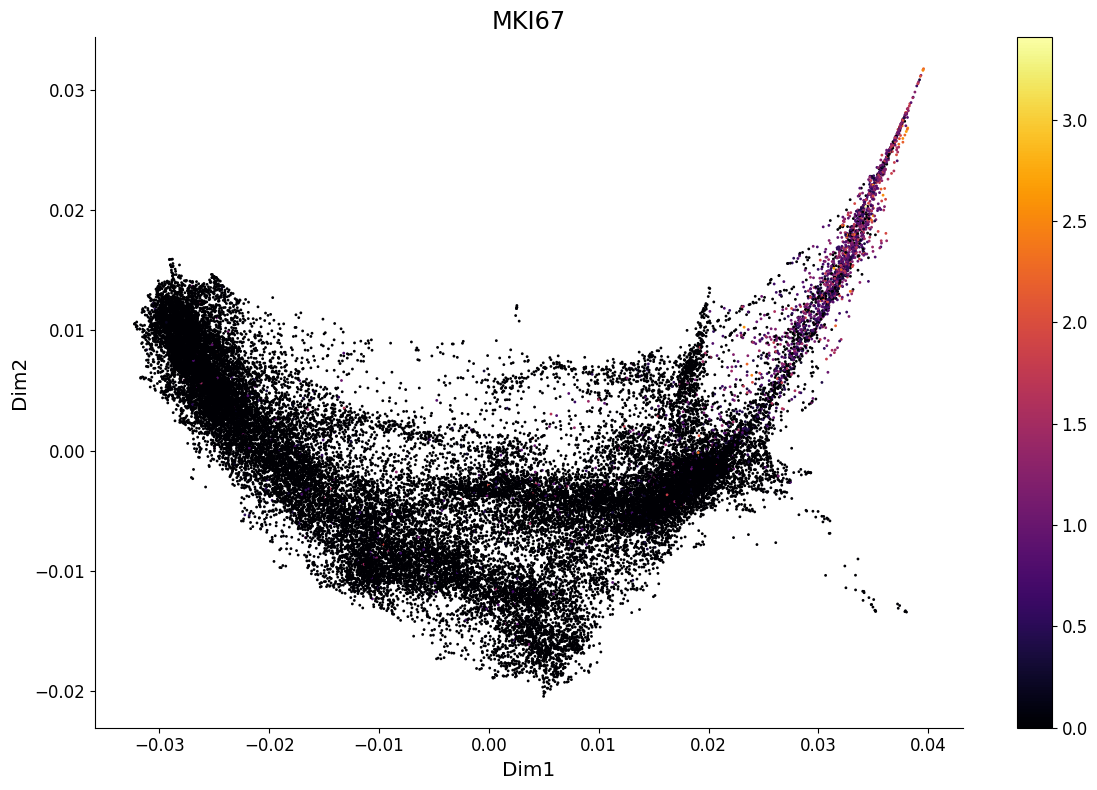

In [36]:
scprep.plot.scatter2d(df_ALL, c=MKI67_color, figsize=(12,8),
                      ticks=False, title='MKI67', xticks=True, yticks=True)

In [37]:
sc.pp.neighbors(adata_ALL, use_rep='X_pca_harmony')
imputed_X = palantir.utils.run_magic_imputation(adata_ALL, sim_key='connectivities')

In [38]:
start_cell = "SF11247_TTGAACGGTACCGAGA-1"
pr_res = palantir.core.run_palantir(
    adata_ALL, start_cell, num_waypoints=500, eigvec_key='X_phate'
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.12658032576243083 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 5.085958218574524 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9997
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


# Draw Fig. 2e

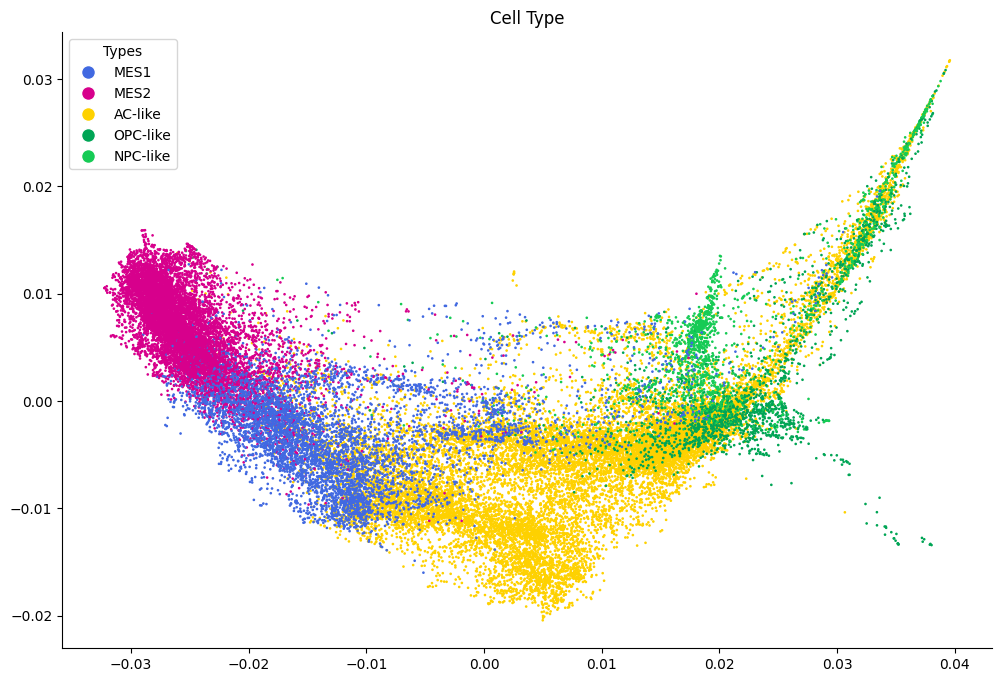

In [39]:
palette = {'MES1':'#4169E1','MES2':'#D7008C','AC-like':'#FED100','OPC-like':'#00A555','NPC-like':'#16CB55'}
color = pd.concat([adata_ALL.obs['annotation'][adata_ALL.obs['annotation'] == 'AC-like'], adata_ALL.obs['annotation'][adata_ALL.obs['annotation'] != 'AC-like']])
plt.figure(figsize=(12,8))
plt.scatter(x=df_ALL['Dim1'].loc[color.index],y=df_ALL['Dim2'].loc[color.index],c=color.map(palette),s=1,marker='h',alpha=1,rasterized=True)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[label], markersize=10, label=label) for label in palette]
plt.legend(handles=handles, title='Types')
plt.title('Cell Type')
plt.grid(False)
plt.savefig('celltype.pdf',dpi=500)

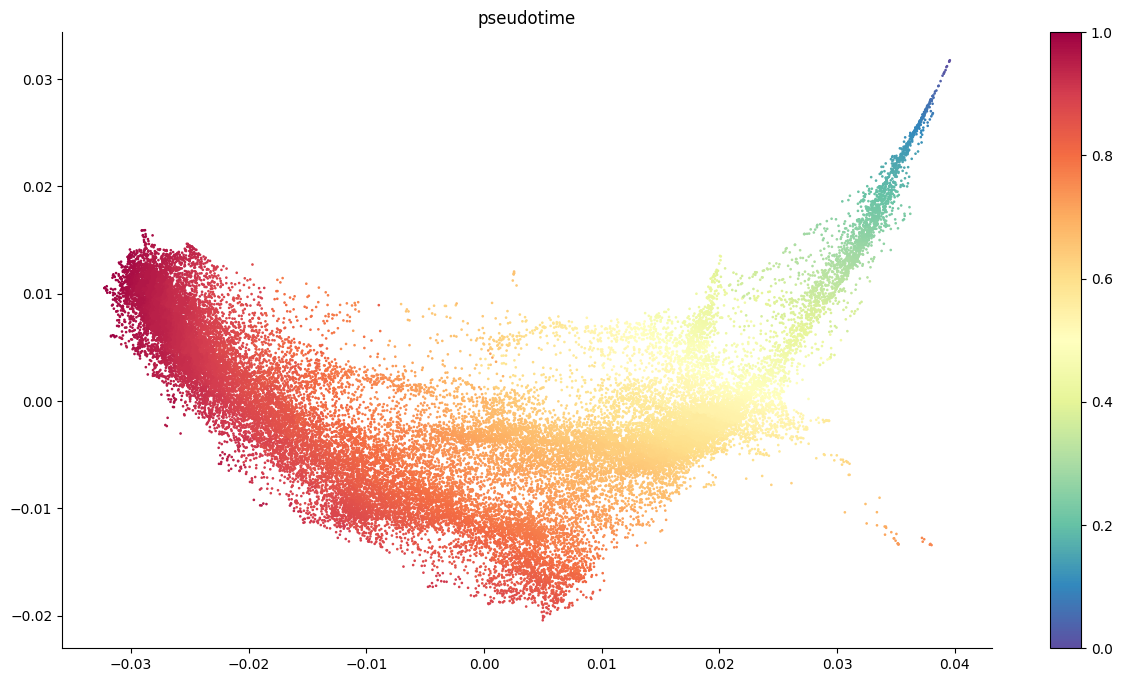

In [40]:
plt.figure(figsize=(15,8))
scatter = plt.scatter(x=df_ALL['Dim1'],y=df_ALL['Dim2'],c=adata_ALL.obs['palantir_pseudotime'],s=1,marker='h',alpha=1,rasterized=True)
plt.colorbar(scatter)
plt.title('pseudotime')
plt.grid(False)
plt.savefig('pseudotime.pdf',dpi=500)

# Draw Fig. 2f

/tmp/ipykernel_104119/1413088492.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['annotation'] == 'NPC-like', "palantir_pseudotime"], shade=True, color='#16CB55', label="NPC-like", alpha=.7)
/tmp/ipykernel_104119/1413088492.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['annotation'] == 'OPC-like', "palantir_pseudotime"], shade=True, color='#00A555', label="OPC-like", alpha=.7)
/tmp/ipykernel_104119/1413088492.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['annotation'] == 'AC-like', "palantir_pseudotime"], shade=True, color='#FED100', label="AC-like", alpha=.7)
/tmp/ipykernel_

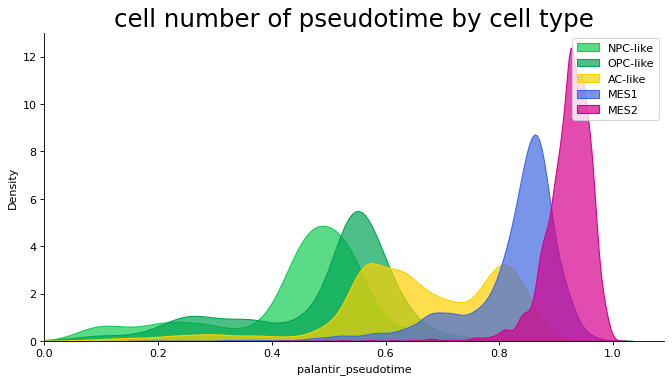

In [41]:
df = adata_ALL.obs
plt.figure(figsize=(10,5), dpi=80)
sns.kdeplot(df.loc[df['annotation'] == 'NPC-like', "palantir_pseudotime"], shade=True, color='#16CB55', label="NPC-like", alpha=.7)
sns.kdeplot(df.loc[df['annotation'] == 'OPC-like', "palantir_pseudotime"], shade=True, color='#00A555', label="OPC-like", alpha=.7)
sns.kdeplot(df.loc[df['annotation'] == 'AC-like', "palantir_pseudotime"], shade=True, color='#FED100', label="AC-like", alpha=.7)
sns.kdeplot(df.loc[df['annotation'] == 'MES1', "palantir_pseudotime"], shade=True, color='#4169E1', label="MES1", alpha=.7)
sns.kdeplot(df.loc[df['annotation'] == 'MES2', "palantir_pseudotime"], shade=True, color='#D7008C', label="MES2", alpha=.7)
# rasterized=True
plt.title('cell number of pseudotime by cell type', fontsize=22)
plt.xlim(left=0)
plt.legend()
plt.savefig('cellnumber.pdf',dpi=500)
plt.show()